**Table of contents**<a id='toc0_'></a>    
- [Import Statements](#toc1_1_)    
- [Getting to Know the Data](#toc2_)    
  - [*Data summarization*](#toc2_1_)    
  - [*Analyzing categorical data*](#toc2_2_)    
  - [*Analyzing numerical data*](#toc2_3_)    
    - [*Handling outliers*](#toc2_3_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=5
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

### <a id='toc1_1_'></a>[Import Statements](#toc0_)

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

## <a id='toc2_'></a>[Getting to Know the Data](#toc0_)

In [2]:
planes = pd.read_csv("../datasets/planes.csv")

In [3]:
planes.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882.0
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218.0
2,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302.0
3,SpiceJet,24/06/2019,Kolkata,Banglore,CCU → BLR,09:00,11:25,2h 25m,non-stop,No info,3873.0
4,Jet Airways,12/03/2019,Banglore,New Delhi,BLR → BOM → DEL,18:55,10:25 13 Mar,15h 30m,1 stop,In-flight meal not included,11087.0


In [4]:
planes.isna().sum()

Airline            427
Date_of_Journey    322
Source             187
Destination        347
Route              256
Dep_Time           260
Arrival_Time       194
Duration           214
Total_Stops        212
Additional_Info    589
Price              616
dtype: int64

In [5]:
# We will remove the rows from a column if it has <= 5% of the total rows missing
threshold = len(planes) * 0.05
subset_of_columns_to_remove_rows_from = planes.columns[planes.isna().sum() <= threshold]

In [6]:
planes = planes.dropna(subset=subset_of_columns_to_remove_rows_from)

In [7]:
# The Additional_Info column has no information of value
planes = planes.drop(columns="Additional_Info")
# Handling missing values in the Price column
planes = planes.assign(Price=planes.groupby("Airline").Price.transform(lambda grp: grp.fillna(grp.median())))

In [8]:
planes.isna().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Price              0
dtype: int64

### <a id='toc2_1_'></a>[*Data summarization*](#toc0_)

- Use `.groupby()` to group the data and then use `.agg()`/`.transform()`/`.filter()` to summarize and explore the dataset. To visually represent the findings we can use a `barplot`.

### <a id='toc2_2_'></a>[*Analyzing categorical data*](#toc0_)

- Select the object columns using `.select_dtypes("object")` and then use `.value_counts()` to see the distribution of the categories. We can also use `.value_counts(normalize=True)` to see the proportions of the categories. If there are too many categories, this might not be very useful. In that case we can use, `.numunique()` to see the number of unique categories and use the `.unique()` method to see the name of those unique categories.

- If the categorical column has comparatively few categories we can covert them to *category* type with `.astype("category")`. For columns with large number of categories, we should try to group them into smaller number of super-categories with some filtering logics. For filtering the data, functions like `np.select()`, `df.query()`, `df.loc[]`, `df.where()` etc. can be very useful.

In [9]:
planes.select_dtypes("object").nunique()

Airline               8
Date_of_Journey      44
Source                5
Destination           6
Route               122
Dep_Time            218
Arrival_Time       1220
Duration            362
Total_Stops           5
dtype: int64

In [10]:
# The "Airline", "Source", "Destination" columns should be converted to categorical type
# The "Total_Stops" column can be converted to int type or categorical type

In [11]:
planes.Total_Stops.value_counts()

Total_Stops
1 stop      4467
non-stop    2786
2 stops     1219
3 stops       35
4 stops        1
Name: count, dtype: int64

In [12]:
# The "Date_of_Journey", "Dep_Time" and "Arrival_Time" should be converted to datetime objects

In [13]:
planes.Dep_Time.head()

0    09:25
1    18:05
2    16:50
3    09:00
4    18:55
Name: Dep_Time, dtype: object

In [14]:
planes.Arrival_Time.head()

0    04:25 10 Jun
1           23:30
2           21:35
3           11:25
4    10:25 13 Mar
Name: Arrival_Time, dtype: object

In [15]:
# "Duration" should be number type

In [16]:
planes.Duration.head()

0        19h
1     5h 25m
2     4h 45m
3     2h 25m
4    15h 30m
Name: Duration, dtype: object

In [17]:
# Looks like this won't be simple to convert to numbers. However for now, we could categorize flights by 
# duration and examine the frequency of different flight lengths

In [18]:
# list of super categories
flight_categories = ["Short-haul", "Medium", "Long-haul"]

# categorize as short_flights 
# doesn't work with .str.startswith("0h|1h...") so this way (^ for denoting startswith and | for "or")
short_flights_startswith = "^0h|^1h|^2h|^3h|^4h"

# categorize as medium_flights
medium_flights_startswith = "^5h|^6h|^7h|^8h|^9h"

# categorize as long_flights
long_flights_startswith = "10h|11h|12h|13h|14h|15h|16h"

# otherwise "Extreme duration"

In [19]:
# the conditions list to be used with np.select
conditions = [
    (planes["Duration"].str.contains(short_flights_startswith)),
    (planes["Duration"].str.contains(medium_flights_startswith)),
    (planes["Duration"].str.contains(long_flights_startswith))
]

In [20]:
# we use np.select(condlist, choicelist, default) to categorize the flight durations and create a new column
planes["Duration_Category"] = np.select(condlist=conditions, 
                                        choicelist=flight_categories,
                                        default="Extreme duration")

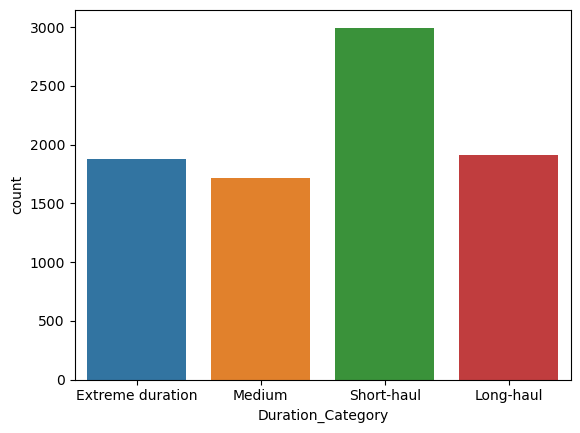

In [21]:
# plot the counts of each super category
sns.countplot(data=planes, x="Duration_Category")
plt.show()

### <a id='toc2_3_'></a>[*Analyzing numerical data*](#toc0_)

- Sometimes there are columns that should be "number" type but are stored as strings or objects. Most of the times the reason is that the data in those columns has some string characters in them (mostly commas ","). In those cases we can utilize the `.str` accessor to perform string operations on the columns if necessary. We can also use the `.replace()` to replace a string with another or we can also use the `.str.replace()` method to replace a string partially. 

In [22]:
# our Duration column has "h" and "m" in it. let's try to convert them to proper float values
temp_dur = planes.Duration.str.split(" ", expand=True).replace("h", "", regex=True).replace("m", "", regex=True).fillna(0).astype("int")
temp_dur.loc[:, 1] = round(temp_dur.loc[:, 1]/60, 3)
planes["Duration"] = temp_dur.loc[:, 0] + temp_dur.loc[:, 1]

In [23]:
planes.Duration.head()

0    19.000
1     5.417
2     4.750
3     2.417
4    15.500
Name: Duration, dtype: float64

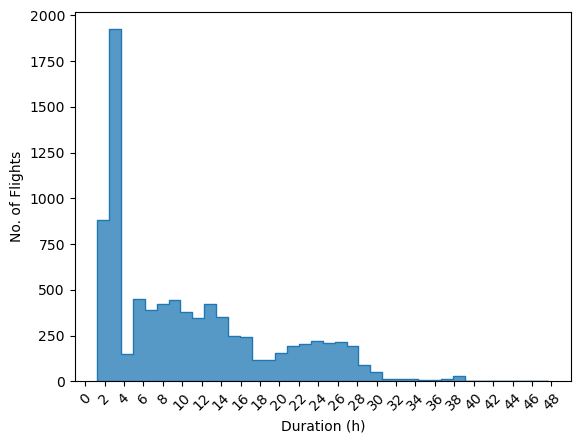

In [24]:
# let's visualize the distribution
ax = sns.histplot(data=planes, x="Duration", element="step")
ax.set_xticks(range(0, 50, 2), range(0, 50, 2), rotation=45)
ax.set(xlabel="Duration (h)", ylabel="No. of Flights")
plt.show()

> *Adding descriptive statistical columns*

- Sometimes we may want to add some columns to the original dataframe, that describes some properties of the numerical columns such as, median, mean, standard deviation etc. And it is often the case that we want to add these columns for each group of a categorical column. In those cases we can use the `.groupby()` method to group the data, select the columns we want to calculate descriptive statistics for and then use `.transform()` to add the new columns against the original indexes.

In [25]:
# Let's say we want to add a column to planes containing the standard deviation of "Price" based on "Airline"
planes["airline_price_st_dev"] = planes.groupby("Airline")["Price"].transform(lambda grp: grp.std())

print(planes[["Airline", "airline_price_st_dev"]].value_counts())

Airline            airline_price_st_dev
Jet Airways        4159.846432             3082
IndiGo             2245.529140             1632
Air India          3692.609285             1399
Multiple carriers  3558.323763              959
SpiceJet           1798.900648              653
Vistara            2888.915498              376
Air Asia           1979.826234              260
GoAir              2764.926625              147
Name: count, dtype: int64


#### <a id='toc2_3_1_'></a>[*Handling outliers*](#toc0_)

- Outliers are data points that are significantly different from the remaining data. To identify outliers we first need to calculate the IQR. To find the IQR we can use the `.quantile()` method first to find the 25th and 75th percentile and then, $IQR = Q3 - Q2$. Then we can use the IQR to find the upper and lower bounds of the data. The upper bound is $Q3 + 1.5*IQR$ and the lower bound is $Q1 - 1.5*IQR$. 
- We can use simple boolean logic to see which data points are outliers (e.g, $data < lower \ | \ data > upper$).  

- What to do about the outliers? 
  - Once we know we have outliers, we need to decide what to do. It's helpful to ask ourselves why these outliers exist. For example, plane ticket prices can be very high depending on the class and destination distance. If an airline runs both short and long distance flights then they can have high standard deviation in their ticket prices, so in this case the outliers could be representative of a subset of our data. If this is the case, we could just leave them alone.

  - Alternatively, do we know whether the values are accurate? Could there have been an error in data collection? If there's an error, we could remove the values. 
  
  - There are so many other things that we can do. We can just drop the outliers with `.drop()` method or filter out the outliers with simple boolean logic. Or we can clip the values to the upper and lower bounds with `.clip()` method. Or we can replace them at first with Nan values and then impute them with the mean/median/mode values or interpolate them (if the data is ordered) or we can even apply ML algorithms. So there are multitude of possibilities. We need to decide based on our data and the context.

It can be difficult deciding what to do with outliers, but you must know how to handle them as they often occur in the real-world.

In [26]:
# let's say we want to inspect the Price column for outliers
planes.Price.describe()

count     8508.000000
mean      9033.468441
std       4366.382574
min       1759.000000
25%       5228.000000
50%       8452.000000
75%      12242.000000
max      54826.000000
Name: Price, dtype: float64

In [27]:
# Find the 75th and 25th percentiles
price_seventy_fifth = planes["Price"].quantile(0.75)
price_twenty_fifth = planes["Price"].quantile(0.25)

# Calculate iqr
prices_iqr = price_seventy_fifth - price_twenty_fifth

# Calculate the thresholds
upper = price_seventy_fifth + (1.5 * prices_iqr)
lower = price_twenty_fifth - (1.5 * prices_iqr)

In [28]:
# See summary statistics for the outliers
planes[(planes["Price"] < lower) | (planes["Price"] > upper)].Price.describe()

count       70.000000
mean     27838.442857
std       5533.992156
min      22794.000000
25%      25735.000000
50%      26890.000000
75%      27992.000000
max      54826.000000
Name: Price, dtype: float64

In [29]:
# Subset the data to remove outliers
planes = planes[(planes["Price"] > lower) & (planes["Price"] < upper)]

print(planes["Price"].describe())

count     8438.000000
mean      8877.466046
std       4001.838236
min       1759.000000
25%       5224.000000
50%       8372.000000
75%      12121.000000
max      22270.000000
Name: Price, dtype: float64
